# Model-Free TD Control: Q-Learning and SARSA

**本notebook包含2个习题(Exercise 1\~2)和5个代码填空(Programming 1\~5)。**


## 时间差分学习 Temporal Difference(TD)：
1. TD结合了Dynamic Programming(动态规划，下称DP)和 MonteCarlo方法(蒙特卡洛方法，下称MC)的思想。TD和MC的共同优势是可以从原始经验中学习，不需要知道环境模型；TD不需要仿真出完整的轨迹，直接利用其它状态的估计来更新当前状态值，这一点和DP方法很类似。
2. DP、MC、TD三者的具体方法都是广义策略迭代的思想，在预测阶段，即值函数评估，三种方法各不相同，DP使用Bellman方程，MC使用采样回报均值，TD则是通过对已计算出的结果进行更新。


## on-policy & off-policy
1. on-policy：生成样本的policy（value function）跟网络更新参数时使用的policy（value function）相同。典型为SARAS算法，基于当前的policy直接执行一次动作选择，然后用这个样本更新当前的policy，因此生成样本的policy和学习时的policy相同，算法为on-policy算法。该方法会遭遇探索-利用的矛盾，光利用目前已知的最优选择，可能学不到最优解，收敛到局部最优，而加入探索又降低了学习效率。epsilon-greedy 算法是这种矛盾下的折衷。优点是直接了当，速度快，劣势是不一定找到最优策略。

2. off-policy：生成样本的policy（value function）跟网络更新参数时使用的policy（value function）不同。典型为Q-learning算法，计算下一状态的预期收益时使用了max操作，直接选择最优动作，而当前policy并不一定能选择到最优动作，因此这里生成样本的policy和学习时的policy不同，为off-policy算法。先产生某概率分布下的大量行为数据（behavior policy），意在探索。从这些偏离（off）最优策略的数据中寻求target policy。当然这么做是需要满足数学条件的：假設π是目标策略, µ是行为策略，那么从µ学到π的条件是：$\pi(a|s) > 0$ 必然有 $\mu (a|s) > 0$成立。

3. 两种学习策略的关系是：on-policy 是 off-policy 的特殊情形，其 target policy 和 behavior policy 是一个。劣势是曲折，收敛慢，但优势是更为强大和通用。其强大是因为它确保了数据全面性，所有行为都能覆盖。





## 运行环境：Cliff Walking

![Image Name](https://cdn.kesci.com/upload/image/q9v4d39ald.png)
这是一个标准的无折扣、分阶段、有起点和终点的模型，在每个位置通常有上下左右四种操作，在悬崖格子上的reward是-100，其他格子的reward是-1。而且如果走到了悬崖格子，会被直接传送到起点。

In [1]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
class Env():
    def __init__(self, length, height):
        self.length = length        #模型的长，我们采用12
        self.height = height        #模型的宽，我们采用4
        self.x = 0                  #记录当前位置横坐标
        self.y = 0                  #记录当前位置纵坐标

    def render(self, frames=50):
        for i in range(self.height):
            if i == 0: 
                line = ['S'] + ['x']*(self.length - 2) + ['T'] #设置左下角位置为起点，右下角位置为重点
            else:
                line = ['.'] * self.length #普通的格子，走上去有-1的reward
            if self.x == i:
                line[self.y] = 'o' #墙壁所在位置如上图所示
            print(''.join(line))
        print('\033['+str(self.height+1)+'A')  
        time.sleep(1.0 / frames)

    def step(self, action): #外部调用这个函数来让当前位置改变
        """4 legal actions, 0:up, 1:down, 2:left, 3:right"""
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.x = min(self.height - 1, max(0, self.x + change[action][0]))
        self.y = min(self.length - 1, max(0, self.y + change[action][1]))

        states = [self.x, self.y]
        reward = -1
        terminal = False
        if self.x == 0: 
            if self.y > 0:
                terminal = True
                if self.y != self.length - 1:
                    reward = -100
        return reward, states, terminal

    def reset(self): #交互程序回归初始状态
        self.x = 0
        self.y = 0

基于该环境，先定义基本算法框架

In [2]:
class Base_Q_table():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        self.table = [0] * actions * length * height # 初始化Q(s,a)这个表
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha #学习率
        self.gamma = gamma #衰减参数

    def _index(self, a, x, y):
        return a * self.height * self.length + x * self.length + y

    def best_direction(self, x, y):
        mav = -100000
        mapos = -1
        for i in range(self.actions):
            if(self.table[self._index(i,x,y)] > mav):
                mav = self.table[self._index(i,x,y)]
                mapos = i
        return mapos

    def _epsilon(self, num_episode): #我们这里采用了衰减的epsilon以获得相对优秀的收敛效果
        return min(0.5, 20. / (num_episode + 1))

    def max_q(self, x, y):
        action = self.best_direction(x, y)
        return self.table[self._index(action,x,y)]
        
    def take_action(self, x, y, num_episode): #选取下一步的操作
        ########################################
        ## Programming 1: epsilon-greedy选取动作
        ########################################
        action = 0
        if random.random() > self._epsilon(num_episode):
            action = self.best_direction(x, y)
        else:
            action = random.randint(1, self.actions-1)
        return action

    def update(self, direct, next_direct, s0, s1, reward, is_terminated):
        pass
        
    
    


## SARSA

算法介绍
1. 对于当前策略执行获得的每个sarsa五元组，其中s指状态，a指动作，r指回报，每次转移涉及的五个量构成了它的名称
2. SARSA是对状态-动作值函数进行更新
3. 是一种On-policy Control的方法
4. 是一种模型无关的方法

使用SARSA的在线策略控制 on-policy
1. 策略评估：SARSA $Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma Q(s', a') - Q(s, a))$
2. 策略改进：$\varepsilon$-greedy 策略改进
3. 因为on-policy，所以SARSA中两个A都是来自同一个策略（当前策略）


## SARSA实战代码

In [3]:
class Q_table_sarsa(Base_Q_table):
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        super().__init__(length, height, actions, alpha, gamma)

    def update(self, direct, next_direct, s0, s1, reward, is_terminated):
        ########################################
        ## Programming 2: 更新Q函数表self.table
        ########################################
        q_predict = self.table[self._index(direct, s0[0], s0[1])]
        if is_terminated:
            q_target = reward
        else:
            q_target = reward + self.gamma * self.table[self._index(next_direct, s1[0], s1[1])]
        self.table[self._index(direct, s0[0], s0[1])] += self.alpha * (q_target - q_predict)

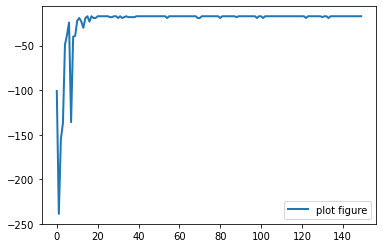

In [4]:
val = [0] * 150
x = [0] * 150


def cliff_walk_sarsa():
    env = Env(length=12, height=4)
    table = Q_table_sarsa(length=12, height=4)
    for num_episode in range(3000):
        episodic_reward = 0
        is_terminated = False
        s0 = [0, 0]
        action = table.take_action(s0[0], s0[1], num_episode)
        while not is_terminated:

            reward, s1, is_terminated = env.step(action)
            next_action = table.take_action(s1[0], s1[1], num_episode)

            episodic_reward += reward

            table.update(action, next_action, s0, s1, reward, is_terminated)

            s0 = s1
            action = next_action

        if num_episode % 20 == 0:
            val[(int)(num_episode/20)] = episodic_reward

        env.reset()


cliff_walk_sarsa()

for i in range((int)(3000/20)):
    x[i] = i
plt.plot(x, val, ls="-", lw=2, label="plot figure")
plt.legend()
plt.show()


参考训练过程如下：

![SARSA运行参考结果](https://cdn.kesci.com/upload/image/qq0aukv896.png)


## n-step SARSA
伪代码如下：

![Image Name](https://cdn.kesci.com/upload/image/qqrs0vfv3u.png?imageView2/0/w/960/h/960)

注意在遇到terminated state之后仍然有一段更新的过程。


类似SARSA算法，n-step算法就是每次并不是根据上一步的数据更新，而是根据之前n步的数据更新。下面以n=5为例子

## n-step SARSA实战代码

In [5]:
from collections import namedtuple
class Q_table_nstep_sarsa(Base_Q_table):
    def __init__(self, length, height, actions=4, alpha=0.02, gamma=0.9, table = [], n=5):
        # n: n-step 长度
        super().__init__(length, height, actions, alpha, gamma)
        self.n = n
        self.transition = namedtuple("transition", ["state", "action", "reward"])
        self.trajectory = []  # 保存历史轨迹

    def getval(self, tao, n):   
        ########################################
        ## Programming 3: 计算N-step Return $G_{tao:tao+n-1}$
        ########################################
        G = 0
        for i in range(tao+1, min(tao+n, len(self.trajectory))):
            G += self.gamma ** (i-tao-1) * self.trajectory[i].reward
            if tao+n < len(self.trajectory):
                transition_temp = self.trajectory[tao+n]
                state = transition_temp.state
                action = transition_temp.action
                G += self.gamma ** n * self.table[self._index(action, state[0], state[1])]
        return G
        
    def update(self, direct, next_direct, s0, s1, reward, is_terminated): 
        #我们主要修改的点就在这里，每次保留n次的数据，从n次之前的数据来更新，可以看到收敛慢了一些，但是相对稳定。
        ########################################
        ## Programming 4: 更新Q函数表self.table
        ########################################
        T = 0x3f3f3f3f
        self.trajectory.append(self.transition(s0,direct,reward))
        if is_terminated:
            T = len(self.trajectory)
        for i in range(len(self.trajectory)):
            tao = i + self.n - 1
            if tao >= 0:
                G = self.getval(tao, self.n)
                transition_temp = self.trajectory[i]
                state = transition_temp.state
                action = transition_temp.action
                q_predict = self.table[self._index(action, state[0], state[1])]
                self.table[self._index(action, state[0], state[1])] += self.alpha * (G - q_predict)
            if tao == T - 1:
                break
        if is_terminated:
            self.trajectory = []

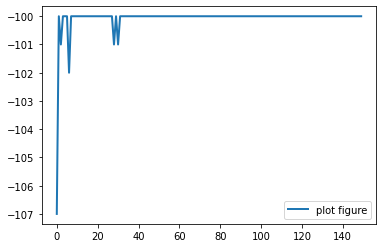

In [6]:
val = [0] * 150
x = [0] * 150
def cliff_walk_nstep_sarsa():
    env = Env(length=12, height=4)
    table = Q_table_nstep_sarsa(length=12, height=4)
    for num_episode in range(3000):
        episodic_reward = 0
        is_terminated = False
        s0 = [0, 0]
        action = table.take_action(s0[0],s0[1],num_episode)
        while not is_terminated:
            
            reward, s1, is_terminated = env.step(action)
            next_action = table.take_action(s1[0],s1[1],num_episode)
            episodic_reward += reward
            
            table.update(action, next_action, s0, s1, reward, is_terminated)
            s0 = s1
            action = next_action

        if num_episode % 20 == 0:
            val[(int)(num_episode/20)] = episodic_reward
        env.reset()
cliff_walk_nstep_sarsa()
for i in range((int)(3000/20)):
    x[i] = i
plt.plot(x, val, ls="-", lw=2, label="plot figure")
plt.legend()
plt.show()


参考训练过程如下：

![Image Name](https://cdn.kesci.com/upload/image/qqrql0yrn6.png?imageView2/0/w/960/h/960)

**Ex1 证明：**
在价值函数$V$不更新的假设下，
$$
G_{t: t+n}-V_{t+n-1}\left(S_{t}\right) =\sum_{k=t}^{t+n-1} \gamma^{k-t} \delta_{k}~，
$$
其中$\delta_{t} = R_{t+1}+\gamma V_{t}\left(S_{t+1}\right)-V_{t}\left(S_{t}\right)$。


## Q-Learning Algorithm

Q-learning算法是一种off-policy的时序差分控制算法, 是model-free RL中出现很早的一个模型, 模型如下

$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \left[ r_{t+1} + \gamma \max_{a\in \mathcal{A}}Q(s_{t+1},a_t) - Q(s_t,a_t) \right]
$$


我们会使用到$\epsilon$-贪心策略来进行动作的选择:
- 以$\epsilon$的概率,随机选择动作
- 以$1-\epsilon$的概率,选择贪心策略下最好的动作



## Q-Learning证明
### 确定环境的情况
我们来考虑一个马尔科夫决策过程，状态值函数$v(s)$和动作状态函数$q(s,a)$分别满足Bellman方程：
$v_{\pi}(s) = \sum\limits_{\alpha\in\mathcal{A}}\pi(a|s)\left(R_s^a+\gamma\sum\limits_{s' \in S}P^{a}_{ss'}v_{\pi}(s')\right)$
$q_{\pi}(s,a) = R^a_s + \gamma \sum\limits_{s'\in S}P_{ss'}^a\sum\limits_{a'\in A}\pi(a'|s')q_{\pi}(s',a')$
	如果已知 $R_s^a$,$P^a_{ss'}$ ，我们面对的是一个model-based问题，理论上存在通过解Bellman方程的方法，来获得策略$\pi$下的动作值函数。但是这样仍然有一个问题：解Bellman方程需要矩阵求逆，而这个操作对于稍微大一点的系统计算量太大，此路常常不通。
### 贪心策略
我们换一个思路，假设有一个最优的值函数，它是所有策略下对值函数最好的估计，同时，动作状态函数也是最优的。我们把能实现最优值函数的策略叫做策略$\pi^*$ ，关于最优策略有一个定理：
1. 对于任意的马尔科夫决策过程，总会有一个最优策略 $\pi^*$  比其余所有策略更好或者相等
2. 所有的最优策略都会让状态值函数取得最高
3. 所有的最优策略都会让动作值函数取得最高
	这个定理的意思是最优策略就是让值函数最大化的策略，而且这个策略总会存在。其实这个定理比较好理解，值函数包含动作状态函数就是对状态或者状态+动作的收益的估计，让收益最大化的策略自然就是最好的策略。

现在我们可以写下Bellman最优方程：
$v_{*}(s) = \max\limits_{a}\left(R_s^a+\gamma\sum\limits_{s' \in S}P^{a}_{ss'}v_{*}(s')\right)$
$q_{*}(s,a) = R^a_s + \gamma \sum\limits_{s'\in S}P_{ss'}^a\max\limits_{a'}q_{*}(s',a')$
虽然现在问题还没有解决，但是我们已经初步看到了Q-learning的算法基础-greedy policy选择动作。
### Value Iteration
只要我们解出Bellman最优方程，就可以获得RL问题的答案，然而我们Bellman最优方程很难解，我们尝试用iteration的方法来解Bellman方程。
Value iteration方法属于动态规划，将MDP问题分成两个子问题：
1.一个当前情况(s)下的最优动作
2.在后续状态(s')下沿着最优策略
继续进行最优性定理告诉我们：
一个策略$\pi(a|s)$在状态s上取得最优值函数$v_{\pi}(s) = v_*(s)$,当且仅当：对于从状态$s$可以到达的任何状态$s'$，$\pi$从状态$s'$中能够获得最优值函数，$v_{\pi}(s') = v_*(s')$。
根据Bellman optimal equation:
$v_{*}(s) = \max\limits_{a}\left(R_s^a+\gamma\sum\limits_{s' \in S}P^{a}_{ss'}v_{*}(s')\right)$
当状态s'的最优值函数已经找到，那么再往前看一步就是状态s的最优值函数。value iteration就是不断迭代Bellman optimal function。这里的直觉来自于Bellman optimal function的"倒着推"：
首先，终结状态的状态值函数是确定
然后，离终结状态的最优值函数可以确定
不断迭代，直到离终结状态最远的最优状态值函数被确定
### 压缩映射定理
现在我们试图来证明value iteration最终收敛到$v_*$。
根据压缩映射定理：
对于任何在算子 $T(v)$下完备(即封闭)的度量空间 $V$ ，如果算子 $T$ 为 $\gamma$-压缩，那么会有：
* $T(v)$ 最终收敛到一个唯一的固定点$v^*$
* 线性收敛速度正比于$\gamma$
这个定理可以这样理解，每次算子 $T(v)$作用到某个v(s)，都会"压缩"v(s)和$v^*$的距离，直到最终收敛到。现在就差算子 $T(v)$ :
事实上我们可以把Bellman optimal equation右边整体看成这个算子，也就是:
$T(v) = \max\limits_{a}R_s^a + \gamma P^av$

我们把这个算子叫做Bellman optimality backup operator，所以只要证明了Bellman optimality back operator是一个$\gamma$ -压缩就行了。
那么什么是$\gamma$ -压缩呢？就是我们称一个算子 $T$为$\gamma$ -压缩，那么会有：
$\|T(u)-T(v)\|_{\infty}\leq\gamma\|u-v\|_{\infty}$,其中$\gamma < 1$
而$\|u-v\|_{\infty} = \max\limits_{s}|u(s)-v(s)|$表示两个值函数在任意状态上面的最大差距。
对于Bellman optimality backup operator:

![Image Name](https://cdn.kesci.com/upload/image/qg4def1gei.png?imageView2/0/w/960/h/960)
又由Bell optimal equation，可得value iteration最终收敛到最优值函数。


### 结论的一般化
#### 定理 1
给定一个MDP，满足更新规则$Q_{t+1}(x_t,a_t) = (1-\alpha_t(x_t,a_t))Q_t(x_t,a_t) + \alpha_t(x_t,a_t)[r_t +\gamma \max\limits_{b\in A}Q_t(x_{t+1},b)]$， 那么它将收敛到最优的Q-function当且仅当
(1) $\sum_t\alpha_t(x,a)=\infty$
(2) $\sum_t\alpha_t^2(x,a)<\infty$

#### 证明
不妨令$\Delta_t(x,a) = Q_t(x,a) - Q^{*}(x,a)$
从而得到 $\Delta_{t}(x_t,a_t) = (1-\alpha_t(x_t,a_t))\Delta_t(x_t,a_t) + \alpha_t(x_t,a_t)[r_t +\gamma \max\limits_{b\in A}Q_t(x_{t+1},b) - Q^{*}(x_t,a_t)]$
定义一个函数$F_t(x,a) = r(x,a,X(x,a)) + \gamma\max\limits_{b\in A}Q_t(y,b) - Q^{*}(x,a)$

那么 $E(F_t(x,a))=(TQ_t)(x,a)-Q^{*}(x,a) = (TQ_t)(x,a)-(TQ^{*})(x,a)$
通过上面block的公式，我们知道$E(F_t(x,a))\leq \gamma\|\Delta_t\|$
最终我们得到$var(F_t(x)) = var[r(x,a,X(x,a))+\gamma\max\limits_{b\in A}Q_t(y,b)]\leq C(1+\|\Delta_t\|^2)$
这里C是一个常数
#### 引理
对一个随机过程$\Delta_t$，满足$\Delta_{t+1}(x) = (1-\alpha_t(x))\Delta_t(x)+\alpha_t(x)F_t(x)$，那么它将收敛到0当且仅当
(1) $\sum_t\alpha_t(x,a)=\infty$
(2) $\sum_t\alpha_t^2(x,a)<\infty$
(3) $E(F_t(x))\leq \gamma\|\Delta_t\|$
(4) $var(F_t(x))\leq C(1 + \|\Delta_t\|^2)$, C>0

由此引理，我们就得到了Q-learning的收敛性。

## Q-Learning实战代码

In [7]:
class Q_table(Base_Q_table):
    def __init__(self, length, height, gamma, actions=4, alpha=0.005):
        super().__init__(length, height, actions, alpha, gamma)

    def update(self, a, s0, s1, r, is_terminated):
        #和前面两种方法区别最大的就是这里，区别在于Q Learning直接基于当前数据来更新，而非以前算出的数据
        #这里就是on-policy和off-policy的区别所在
        ########################################
        ## Programming 5: 更新table
        ########################################
        q_predict = self.table[self._index(a, s0[0], s0[1])]
        if is_terminated:
            q_target = r
        else:
            a_next = self.best_direction(s1[0], s1[1])
            q_target = r + self.table[self._index(a_next, s1[0], s1[1])]
        self.table[self._index(a, s0[0], s0[1])] += self.alpha * (q_target - q_predict)

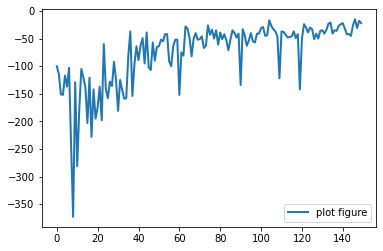

In [8]:
import matplotlib.pyplot as plt
import numpy as np
val = [0] * 150
x = [0] * 150
def cliff_walk():
    env = Env(length=12, height=4)
    table = Q_table(length=12, height=4, gamma=0.9)
    for num_episode in range(3000):
        episodic_reward = 0
        is_terminated = False
        s0 = [0, 0]
        while not is_terminated:
            action = table.take_action(s0[0], s0[1], num_episode)
            r, s1, is_terminated = env.step(action)
            table.update(action, s0, s1, r, is_terminated)
            episodic_reward += r
            s0 = s1
        if num_episode % 20 == 0:
            val[(int)(num_episode/20)] = episodic_reward;
        env.reset()
cliff_walk()
for i in range((int)(3000/20)):
    x[i] = i
plt.plot(x, val, ls="-", lw=2, label="plot figure")
plt.legend()
plt.show()

参考的训练过程如下：

![Image Name](https://cdn.kesci.com/upload/image/qq0f54jk5e.png?imageView2/0/w/960/h/960)


## 下面是不同gamma对收敛率的影响

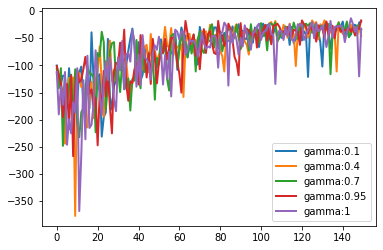

In [9]:
val = [0] * 150
x = [0] * 150
def cliff_walk1(ngamma):
    env = Env(length=12, height=4)
    table = Q_table(length=12, height=4, gamma=ngamma)
    for num_episode in range(3000):
        episodic_reward = 0
        is_terminated = False
        s0 = [0, 0]
        while not is_terminated:
            action = table.take_action(s0[0], s0[1], num_episode)
            r, s1, is_terminated = env.step(action)
            table.update(action, s0, s1, r, is_terminated)
            episodic_reward += r
            s0 = s1
        if num_episode % 20 == 0:
            val[(int)(num_episode/20)] = episodic_reward;
        env.reset()
for i in range((int)(3000/20)):
    x[i] = i
cliff_walk1(0.1)
plt.plot(x, val, ls="-", lw=2, label="gamma:0.1")
cliff_walk1(0.4)
plt.plot(x, val, ls="-", lw=2, label="gamma:0.4")
cliff_walk1(0.7)
plt.plot(x, val, ls="-", lw=2, label="gamma:0.7")
cliff_walk1(0.95)
plt.plot(x, val, ls="-", lw=2, label="gamma:0.95")
cliff_walk1(1)
plt.plot(x, val, ls="-", lw=2, label="gamma:1")
plt.legend()
plt.show()

**Ex2 可以看到不同的$\gamma$对收敛的效果影响非常大，请思考其中的原因，并写出$\gamma \in [0,1]$过大或者过小所带来的影响。**

# 总结
Sarsa和Q-Learning算法是强化学习中两个非常基础的算法，也是在实践过程中比较好用的算法。掌握这两个基础算法对将来进行深层次的学习很有帮助。不同的学习率$\alpha$和超参数$\gamma$对收敛速率的影响比较大，但如果学习率过高就可能无法达到最优解。$\epsilon$-greedy算法中的$\epsilon$也是非常重要的参量，对平衡探索和利用的关系非常重要。